In [1]:
from google.colab import files
import io

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers as L
from sklearn import preprocessing


import matplotlib
import matplotlib.pyplot as plt

# %load_ext tensorboard
# !rm -rf ./logs/
# from tensorflow.keras.callbacks import TensorBoard
# from tensorboard.plugins.hparams import api as hp


In [2]:
uploaded = files.upload()

Saving train.json to train (1).json


In [3]:
train = pd.read_json(io.BytesIO(uploaded['train.json']),lines=True)
train = train[train.SN_filter == 1]
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [4]:
def preprocess_inputs(df,input_cols):
    """
    Converts inputs into one-hot
    """
    output = []
    for i in range(len(input_cols)):
        tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(np.asarray(df[input_cols[i]]))
        tmp = tokenizer.texts_to_sequences(np.asarray(df[input_cols[i]]))
        new_var = np.asarray(keras.utils.to_categorical(tmp)[:,:,1:])
        if new_var.shape[1] != 130:
            longer = np.full((new_var.shape[0], 130, new_var.shape[2]), np.float32(0))
            for seq_index in range(len(new_var)):
                tmp = new_var[seq_index]
                row_len = len(tmp[0])
                new_line = np.full(row_len, -10, np.float32)
                while len(tmp) != 130:
                    tmp = np.vstack((tmp, new_line))
                longer[seq_index] = tmp
            output.append(longer)
        else:
            output.append(new_var)
    return output



def merge_inputs(inputs):
    """
    Merges the one-hot inputs by columns
    transform in numpy array
    """
    size = len(inputs[0])
    output = []
    for i in range(size):
        output.append(np.concatenate((inputs[0][i], inputs[1][i], inputs[2][i]), axis = 1))
    return np.asarray(output)


def preprocess_results(df, results, train = True):
    """
    Makes sure that the results are in the appropriate format:
        [layers,lines,columns] in an np array
    """
    tmp = np.asarray(df[results])
    size = len(tmp[0])
    output = np.zeros((len(tmp),len(tmp[0][0]),len(results)))
    for i in range(len(results)):
        for j in range(size):
            tmp[i,j] = np.asarray(tmp[i,j])
    for i in range(len(tmp)):
        output[i] = np.vstack((tmp[i,0], tmp[i,1], tmp[i,2]))[:,:].T
    return output



def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

In [5]:
inputs_ohe = preprocess_inputs(train, input_cols)
inputs_array = merge_inputs(inputs_ohe)
expected_results = preprocess_results(train, pred_cols)

In [7]:
#### MODEL GRU Bidirectionnal ####

def build_gru(output_length, lr, dropout1, dropout2, dropout3,
              input_shape = (130,14), 
              space_dropout = 0.2,
              masking_val = np.float32(-10)) :
    
    opt = tf.keras.optimizers.Adam(learning_rate = lr)

    inputs = L.Input(shape = input_shape)
    mask   = L.Masking(mask_value=np.float32(masking_val))(inputs)
    mask   = L.SpatialDropout1D(space_dropout)(mask)
    
    x1 = L.Bidirectional(L.GRU(units = 300, dropout = dropout1, return_sequences = True))(mask)
    
    x2 = L.Bidirectional(L.GRU(units = 150, dropout = dropout2, return_sequences = True))(x1)
    x3 = L.Bidirectional(L.GRU(units = 70,  dropout = dropout3, return_sequences = True))(x2)
    
    # cut masking values
    sliced_layer = x3[:, :output_length]
    out_layer = L.Dense(3, activation = 'linear')(sliced_layer)
    
    model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model_gru.compile(opt, loss = 'mse', metrics = MCRMSE) #[keras.metrics.RootMeanSquaredError()]
    
    return model_gru

In [ ]:
####### Variation du LR de 1e-7 à 1e-1 ######

dropout = 0.5
output_length=68
batch_size=64
epochs=100
validation_split = 0.1


model_LR01 = build_gru(output_length, lr=0.1, dropout1=dropout, dropout2=dropout, dropout3=dropout)
model_LR02 = build_gru(output_length, lr=0.01, dropout1=dropout, dropout2=dropout, dropout3=dropout)
model_LR03 = build_gru(output_length, lr=0.001, dropout1=dropout, dropout2=dropout, dropout3=dropout)
model_LR04 = build_gru(output_length, lr=0.0001, dropout1=dropout, dropout2=dropout, dropout3=dropout)
model_LR05 = build_gru(output_length, lr=0.000001, dropout1=dropout, dropout2=dropout, dropout3=dropout)
model_LR06 = build_gru(output_length, lr=0.0000001, dropout1=dropout, dropout2=dropout, dropout3=dropout)

history_LR01 = model_LR01.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR02 = model_LR02.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR03 = model_LR03.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR04 = model_LR04.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR05 = model_LR05.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR06 = model_LR06.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)


In [16]:
print(history_LR03.history.keys())

dict_keys(['loss', 'MCRMSE'])


In [34]:

score_LR01 = model_LR01.evaluate(inputs_array, expected_results, verbose =0)
score_LR02 = model_LR02.evaluate(inputs_array, expected_results, verbose =0)
score_LR03 = model_LR03.evaluate(inputs_array, expected_results, verbose =0)
score_LR04 = model_LR04.evaluate(inputs_array, expected_results, verbose =0)
score_LR05 = model_LR05.evaluate(inputs_array, expected_results, verbose =0)
score_LR06 = model_LR06.evaluate(inputs_array, expected_results, verbose =0)

print('LR = 1e-1')
print('Test loss:', score_LR01[0])
print('Test MCRMSE:', score_LR01[1])
print('==============================\n')
print('LR = 1e-2')
print('Test loss:', score_LR02[0])
print('Test MCRMSE:', score_LR02[1])
print('==============================\n')
print('LR = 1e-3')
print('Test loss:', score_LR03[0])
print('Test MCRMSE:', score_LR03[1])
print('==============================\n')
print('LR = 1e-4')
print('Test loss:', score_LR04[0])
print('Test MCRMSE:', score_LR04[1])
print('==============================\n')
print('LR = 1e-5')
print('Test loss:', score_LR05[0])
print('Test MCRMSE:', score_LR05[1])
print('==============================\n')
print('LR = 1e-6')
print('Test loss:', score_LR06[0])
print('Test MCRMSE:', score_LR06[1])
print('==============================\n')


LR = 1e-1
Test loss: 0.28751689195632935
Test MCRMSE: 0.5309927463531494

LR = 1e-2
Test loss: 0.10164948552846909
Test MCRMSE: 0.3174300789833069

LR = 1e-3
Test loss: 0.0641423761844635
Test MCRMSE: 0.2520054280757904

LR = 1e-4
Test loss: 0.10539068281650543
Test MCRMSE: 0.3230680823326111

LR = 1e-5
Test loss: 0.19227443635463715
Test MCRMSE: 0.43601086735725403

LR = 1e-6
Test loss: 0.2890998125076294
Test MCRMSE: 0.5346815586090088



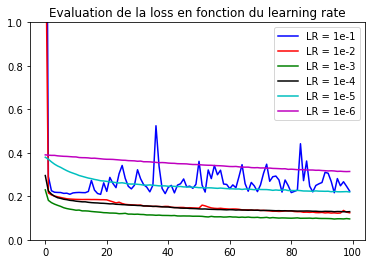

In [43]:
loss1 = history_LR01.history['loss']
loss2 = history_LR02.history['loss']
loss3 = history_LR03.history['loss']
loss4 = history_LR04.history['loss']
loss5 = history_LR05.history['loss']
loss6 = history_LR06.history['loss']

epochs = range(len(loss2))
plt.figure()

plt.plot(epochs, loss1, 'b', label='LR = 1e-1')
plt.plot(epochs, loss2, 'r', label='LR = 1e-2')
plt.plot(epochs, loss3, 'g', label='LR = 1e-3')
plt.plot(epochs, loss4, 'k', label='LR = 1e-4')
plt.plot(epochs, loss5, 'c', label='LR = 1e-5')
plt.plot(epochs, loss6, 'm', label='LR = 1e-6')

plt.title('Evaluation de la loss en fonction du learning rate')

axes = plt.gca()
axes.set_ylim(0, 1)

plt.legend()
plt.show()
#.savefig('foo.png', bbox_inches='tight') 




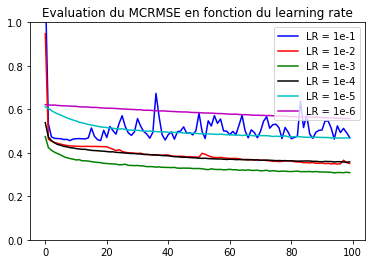

In [50]:
MCRMSE1 = history_LR01.history['MCRMSE']
MCRMSE2 = history_LR02.history['MCRMSE']
MCRMSE3 = history_LR03.history['MCRMSE']
MCRMSE4 = history_LR04.history['MCRMSE']
MCRMSE5 = history_LR05.history['MCRMSE']
MCRMSE6 = history_LR06.history['MCRMSE']

epochs = range(len(loss2))
plt.figure()

plt.plot(epochs, MCRMSE1, 'b', label='LR = 1e-1')
plt.plot(epochs, MCRMSE2, 'r', label='LR = 1e-2')
plt.plot(epochs, MCRMSE3, 'g', label='LR = 1e-3')
plt.plot(epochs, MCRMSE4, 'k', label='LR = 1e-4')
plt.plot(epochs, MCRMSE5, 'c', label='LR = 1e-5')
plt.plot(epochs, MCRMSE6, 'm', label='LR = 1e-6')

plt.title('Evaluation du MCRMSE en fonction du learning rate')
axes = plt.gca()
axes.set_ylim(0, 1)

plt.legend()
plt.show()

In [ ]:
lr=0.001
output_length=68
batch_size=64
epochs=100
validation_split = 0.1


model_LR03_DP01 = build_gru(output_length, lr, dropout1=0.1, dropout2=0.1, dropout3=0.1)
model_LR03_DP02 = build_gru(output_length, lr, dropout1=0.2, dropout2=0.2, dropout3=0.2)
model_LR03_DP03 = build_gru(output_length, lr, dropout1=0.3, dropout2=0.3, dropout3=0.3)
model_LR03_DP04 = build_gru(output_length, lr, dropout1=0.4, dropout2=0.4, dropout3=0.4)
model_LR03_DPmix = build_gru(output_length, lr, dropout1=0.4, dropout2=0.3, dropout3=0.3)

history_LR03_DP01 = model_LR03_DP01.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR03_DP02 = model_LR03_DP02.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR03_DP03 = model_LR03_DP03.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR03_DP04 = model_LR03_DP04.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_LR03_DPmix = model_LR03_DPmix.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)

In [ ]:
model_LR03_DP05 = build_gru(output_length, lr, dropout1=0.5, dropout2=0.5, dropout3=0.5)
history_LR03_DP05 = model_LR03_DP05.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)

In [57]:
score_LR03_DP01 = model_LR03_DP01.evaluate(inputs_array, expected_results, verbose =0)
score_LR03_DP02 = model_LR03_DP02.evaluate(inputs_array, expected_results, verbose =0)
score_LR03_DP03 = model_LR03_DP03.evaluate(inputs_array, expected_results, verbose =0)
score_LR03_DP04 = model_LR03_DP04.evaluate(inputs_array, expected_results, verbose =0)
score_LR03_DPmix = model_LR03_DPmix.evaluate(inputs_array, expected_results, verbose =0)
score_LR03_DP05 = model_LR03_DP05.evaluate(inputs_array, expected_results, verbose =0)


print('Dropout = .1')
print('Test loss:', score_LR03_DP01[0])
print('Test MCRMSE:', score_LR03_DP01[1])
print('==============================\n')
print('Dropout = .2')
print('Test loss:', score_LR03_DP02[0])
print('Test MCRMSE:', score_LR03_DP02[1])
print('==============================\n')
print('Dropout = .3')
print('Test loss:', score_LR03_DP03[0])
print('Test MCRMSE:', score_LR03_DP03[1])
print('==============================\n')
print('Dropout = .4')
print('Test loss:', score_LR03_DP04[0])
print('Test MCRMSE:', score_LR03_DP04[1])
print('==============================\n')
print('dropout = .4, .3, .3')
print('Test loss:', score_LR03_DPmix[0])
print('Test MCRMSE:', score_LR03_DPmix[1])
print('==============================\n')
print('dropout = .5')
print('Test loss:', score_LR03_DP05[0])
print('Test MCRMSE:', score_LR03_DP05[1])
print('==============================\n')

Dropout = .1
Test loss: 0.029928429052233696
Test MCRMSE: 0.1723891645669937

Dropout = .2
Test loss: 0.03653255105018616
Test MCRMSE: 0.190310999751091

Dropout = .3
Test loss: 0.04480522498488426
Test MCRMSE: 0.2106109857559204

Dropout = .4
Test loss: 0.05194021388888359
Test MCRMSE: 0.22677358984947205

dropout = .4, .3, .3
Test loss: 0.050470393151044846
Test MCRMSE: 0.2235080748796463

dropout = .5
Test loss: 0.06158575415611267
Test MCRMSE: 0.24676044285297394



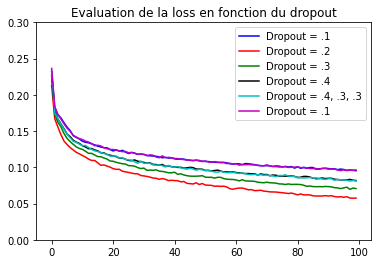

In [62]:
loss1 = history_LR03_DP01.history['loss']
loss2 = history_LR03_DP02.history['loss']
loss3 = history_LR03_DP03.history['loss']
loss4 = history_LR03_DP04.history['loss']
loss5 = history_LR03_DPmix.history['loss']
loss6 = history_LR03_DP05.history['loss']

epochs = range(len(loss2))
plt.figure()

plt.plot(epochs, loss1, 'b', label='Dropout = .1')
plt.plot(epochs, loss2, 'r', label='Dropout = .2')
plt.plot(epochs, loss3, 'g', label='Dropout = .3')
plt.plot(epochs, loss4, 'k', label='Dropout = .4')
plt.plot(epochs, loss5, 'c', label='Dropout = .4, .3, .3')
plt.plot(epochs, loss6, 'm', label='Dropout = .1')

plt.title('Evaluation de la loss en fonction du dropout')

axes = plt.gca()
axes.set_ylim(0, 0.3)

plt.legend()
plt.show()
#.savefig('foo.png', bbox_inches='tight')

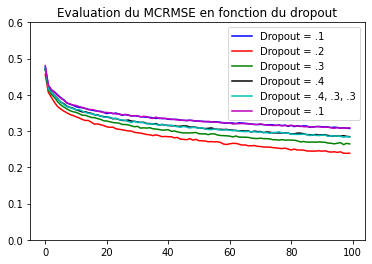

In [64]:
MCRMSE1 = history_LR03_DP01.history['MCRMSE']
MCRMSE2 = history_LR03_DP02.history['MCRMSE']
MCRMSE3 = history_LR03_DP03.history['MCRMSE']
MCRMSE4 = history_LR03_DP04.history['MCRMSE']
MCRMSE5 = history_LR03_DPmix.history['MCRMSE']
MCRMSE6 = history_LR03_DP05.history['MCRMSE']

epochs = range(len(loss2))
plt.figure()

plt.plot(epochs, MCRMSE1, 'b', label='Dropout = .1')
plt.plot(epochs, MCRMSE2, 'r', label='Dropout = .2')
plt.plot(epochs, MCRMSE3, 'g', label='Dropout = .3')
plt.plot(epochs, MCRMSE4, 'k', label='Dropout = .4')
plt.plot(epochs, MCRMSE5, 'c', label='Dropout = .4, .3, .3')
plt.plot(epochs, MCRMSE6, 'm', label='Dropout = .1')

plt.title('Evaluation du MCRMSE en fonction du dropout')
axes = plt.gca()
axes.set_ylim(0, .6)

plt.legend()
plt.show()

In [6]:
#### MODEL GRU Bidirectionnal ####

def build_gru(output_length, act, dropout1 = .1, dropout2 = .1, dropout3 = .1,
              input_shape = (130,14), 
              space_dropout = 0.2,
              masking_val = np.float32(-10)) :
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

    inputs = L.Input(shape = input_shape)
    mask   = L.Masking(mask_value=np.float32(masking_val))(inputs)
    mask   = L.SpatialDropout1D(space_dropout)(mask)
    
    x1 = L.Bidirectional(L.GRU(units = 300, dropout = dropout1, return_sequences = True))(mask)
    
    x2 = L.Bidirectional(L.GRU(units = 150, dropout = dropout2, return_sequences = True))(x1)
    x3 = L.Bidirectional(L.GRU(units = 70,  dropout = dropout3, return_sequences = True))(x2)
    
    # cut masking values
    sliced_layer = x3[:, :output_length]
    out_layer = L.Dense(3, activation = act)(sliced_layer)
    
    model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model_gru.compile(opt, loss = 'mse', metrics = MCRMSE) #[keras.metrics.RootMeanSquaredError()]
    
    return model_gru

In [ ]:
output_length=68
batch_size=64
epochs=100
validation_split = 0.1


model_softmax = build_gru(output_length, 'softmax')
model_linear = build_gru(output_length, 'linear')

history_softmax = model_softmax.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)
history_linear = model_linear.fit(inputs_array, expected_results, batch_size, epochs, validation_split, shuffle = True)


In [8]:
score_softmax = model_softmax.evaluate(inputs_array, expected_results, verbose =0)
score_linear = model_linear.evaluate(inputs_array, expected_results, verbose =0)


print('activation = softmax')
print('Test loss:', score_softmax[0])
print('Test MCRMSE:', score_softmax[1])
print('==============================\n')
print('activation = linear')
print('Test loss:', score_linear[0])
print('Test MCRMSE:', score_linear[1])
print('==============================\n')

activation = softmax
Test loss: 0.21929678320884705
Test MCRMSE: 0.4671992063522339

activation = linear
Test loss: 0.030014652758836746
Test MCRMSE: 0.17261318862438202



In [ ]:
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop', 'adadelta', 'adagrad']))
# HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([0.1, 0.01, 0.001, 0.0001, 0.00001]))

# METRIC_ACCURACY = MCRMSE

# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#   hp.hparams_config(
#     hparams=[HP_DROPOUT, HP_OPTIMIZER, HP_L_RATE],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name=MCRMSE)],
#   )

# ######### HP MODEL #############@

# def build_HP(hparams) :

#     inputs = L.Input(shape = (130,14))
#     mask   = L.Masking(mask_value=np.float32(np.float32(-10)))(inputs)
#     mask   = L.SpatialDropout1D(hparams[HP_DROPOUT])(mask)
    
#     x1 = L.Bidirectional(L.GRU(units = 300, hparams[HP_DROPOUT], return_sequences = True))(mask)
    
#     x2 = L.Bidirectional(L.GRU(units = 150, hparams[HP_DROPOUT], return_sequences = True))(x1)
#     x3 = L.Bidirectional(L.GRU(units = 70,  hparams[HP_DROPOUT], return_sequences = True))(x2)
    
#     # cut masking values
#     sliced_layer = x3[:, :68]
#     out_layer = L.Dense(3, activation = 'linear')(sliced_layer)
    
#     model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
#     model_gru.compile(hparams[HP_OPTIMIZER], loss = 'mse', metrics = [MCRMSE])
    
#     if hparams[HP_OPTIMIZER] == "adam":
#         optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_L_RATE])
#     elif hparams[HP_OPTIMIZER] == "sgd":
#         optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_L_RATE])
#     elif hparams[HP_OPTIMIZER] == "rmsprop":
#         optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_L_RATE])
#     elif hparams[HP_OPTIMIZER] == "adadelta":
#         optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_L_RATE])
#     elif hparams[HP_OPTIMIZER] == "adagrad":
#         optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_L_RATE])        
#     else:
#         raise ValueError("unexpected optimizer name: %r" % (hparams[HP_OPTIMIZER],))

#     model_gru.compile(optimizer=hparams[HP_OPTIMIZER],loss='mse',metrics=[MCRMSE])
    
#     model_gru.fit(inputs_array, expected_results, batch_size=64, epochs=5, validation_split=0.1, shuffle = True)
#   _, MCRMSE = model.evaluate(expected_results)
  
#   return loss


# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     MCRMSE = build_HP(hparams)
#     tf.summary.scalar(METRIC_ACCURACY, MCRMSE, step=1)
